# Exploring cell motility experimental data from Nicola David

Both the MSD and DAC experimental data is set manually and a parameter recovery study is performed using two different models. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-PRW-model-with-no-advection" data-toc-modified-id="Basic-PRW-model-with-no-advection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic PRW model with no advection</a></span><ul class="toc-item"><li><span><a href="#Time-coarsening-50" data-toc-modified-id="Time-coarsening-50-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time coarsening 50</a></span></li><li><span><a href="#Time-coarsening-10" data-toc-modified-id="Time-coarsening-10-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Time coarsening 10</a></span></li></ul></li><li><span><a href="#Outlook:" data-toc-modified-id="Outlook:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Outlook:</a></span></li></ul></div>

## Basic PRW model with no advection

### Time coarsening 50

In [1]:
# Libraries:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics      
from pyabc import SingleCoreSampler

ERROR:External:Install rpy2 to enable simple support for the R language.


In [49]:
file_ = "PRW_Advection.xml"
par_map = {'tau': './Global/Constant[@symbol="tau"]',
           'phi': './Global/Constant[@symbol="phi"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : PRW_Advection.xml
}


Setting the reported values for the MSD and DAC:

In [50]:
true_pars = {'tau': 0.9, 'phi': 0.1}
limits = {key: (0.001 * val, 10 * val) for key, val in true_pars.items()}

# generate ground truth data for recovery study
# simulated_data = model.sample(true_pars)

# experimentally measured data can be entered manually in this format
# the coarse time resolution of 100 times the simulation step size emulates observability limitations of experiments
measured_data = {'IdSumstat__time': np.array([0, 3, 6, 9, 12, 15, 18]),\
                 'IdSumstat__MSD': np.array([0, 120.785327589283, 292.928743729597, 501.711834874178, 750.117246341611, 1049.85016077053, 1366.57530695182]),\
                 'IdSumstat__DAC': np.array([1, 0.468687336131928, 0.366380860294696, 0.320036995887917, 0.280436303333007, 0.260186391843388, 0.227901198640625])}

In [51]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})
#prior = pyabc.Distribution(tau=pyabc.RV("uniform", 0, 1),
#                           phi=pyabc.RV("uniform", 0, 1))

In [55]:
def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][3:],val1['IdSumstat__cell.center.y'][3:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][3:]/val1['IdSumstat__velocity.abs'][3:],val1['IdSumstat__velocity.y'][3:]/val1['IdSumstat__velocity.abs'][3:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [56]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#20
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=26, start_time=2020-11-19 14:51:22.060398, end_time=None)>


In [57]:
abc.run(max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4054.279627312709
INFO:ABC:t: 0, eps: 4054.279627312709.
INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 4029.513119559936.
INFO:ABC:Acceptance rate: 100 / 343 = 2.9155e-01, ESS=9.3465e+01.
INFO:ABC:t: 2, eps: 3977.40560782989.
INFO:ABC:Acceptance rate: 100 / 617 = 1.6207e-01, ESS=8.5843e+01.
INFO:ABC:t: 3, eps: 3585.7739436278002.
INFO:ABC:Acceptance rate: 100 / 392 = 2.5510e-01, ESS=8.3024e+01.
INFO:ABC:t: 4, eps: 2947.22289778521.
INFO:ABC:Acceptance rate: 100 / 326 = 3.0675e-01, ESS=7.9366e+01.
INFO:History:Done <ABCSMC(id=26, start_time=2020-11-19 14:51:22.060398, end_time=2020-11-19 15:01:04.705151)>


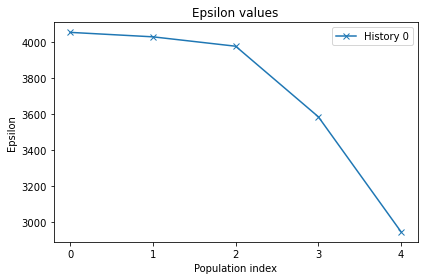

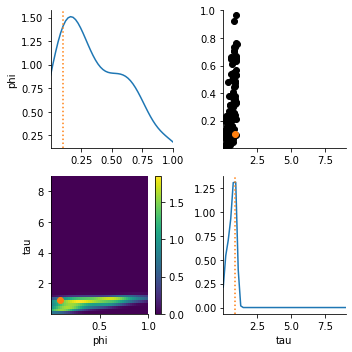

In [58]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

### Time coarsening 10

In [65]:
def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][11:],val1['IdSumstat__cell.center.y'][11:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][11:]/val1['IdSumstat__velocity.abs'][11:],val1['IdSumstat__velocity.y'][11:]/val1['IdSumstat__velocity.abs'][11:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [66]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#20
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=29, start_time=2020-11-19 15:20:39.744442, end_time=None)>


In [67]:
abc.run(max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4078.539250544415
INFO:ABC:t: 0, eps: 4078.539250544415.
INFO:ABC:Acceptance rate: 100 / 210 = 4.7619e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 4072.0861530764305.
INFO:ABC:Acceptance rate: 100 / 445 = 2.2472e-01, ESS=9.2564e+01.
INFO:ABC:t: 2, eps: 4065.145898038.
INFO:ABC:Acceptance rate: 100 / 497 = 2.0121e-01, ESS=7.4481e+01.
INFO:ABC:t: 3, eps: 4029.84927034876.
INFO:ABC:Acceptance rate: 100 / 478 = 2.0921e-01, ESS=8.7988e+01.
INFO:ABC:t: 4, eps: 3925.285575759103.
INFO:ABC:Acceptance rate: 100 / 257 = 3.8911e-01, ESS=6.7880e+01.
INFO:History:Done <ABCSMC(id=29, start_time=2020-11-19 15:20:39.744442, end_time=2020-11-19 15:29:13.892082)>


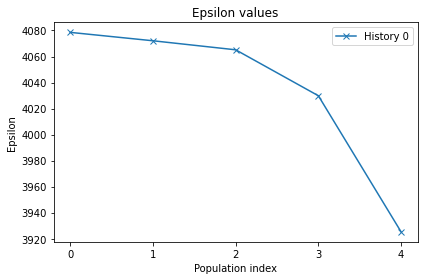

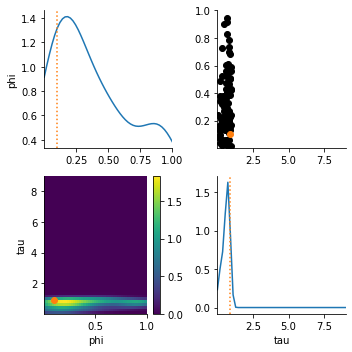

In [68]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

## Outlook:

* Time coarsening does not seem to be critical, some scaling factors seem to appear.
* Implementation of advection is missing, as well as more information on the experimental set-up.
* Running model on HPC facilities. 